# Application of pyKAN for 1D VLBI Data Interpolation

## Introduction

Introduction goes here.

## Imports

In [19]:
import torch
import numpy as np
import pandas as pd
from kan import *
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings

# precoded functions from supplementary modules
from data_preparation import *
from data_visualization import *

## Globals and Settings

In [20]:
# ignore warnings
warnings.filterwarnings(action="ignore")

In [21]:
# initialize torch device as `gpu` if exists else `cpu`
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using `{device}` device for torch.")

Using `cpu` device for torch.


In [22]:
DATASET_FILE = '.\data\Cres_05.txt'

In [23]:
TEST_SIZE = 0.3

In [24]:
# random seed global variable
RANDOM_STATE = 42

# Crest Model Dataset

## Data Loading

In [25]:
# load data from text file indicated in DATASET_FILE global variable
dataset = pd.read_csv(DATASET_FILE, sep='\t')

In [26]:
# general information about dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259200 entries, 0 to 259199
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   U       259200 non-null  float64
 1   V       259200 non-null  float64
 2   Re      259200 non-null  float64
 3   Im      259200 non-null  float64
dtypes: float64(4)
memory usage: 7.9 MB


## EDA

In [27]:
# calculate visibility amplitude and phase and add it to initial dataset
calculate_baseline_amplitude(dataset=dataset, inplace=True, sort_baselines=True)

In [28]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259200 entries, 0 to 259199
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   U          259200 non-null  float64
 1   V          259200 non-null  float64
 2   Re         259200 non-null  float64
 3   Im         259200 non-null  float64
 4   Baseline   259200 non-null  float64
 5   Amplitude  259200 non-null  float64
 6   Phase      259200 non-null  float64
dtypes: float64(7)
memory usage: 13.8 MB


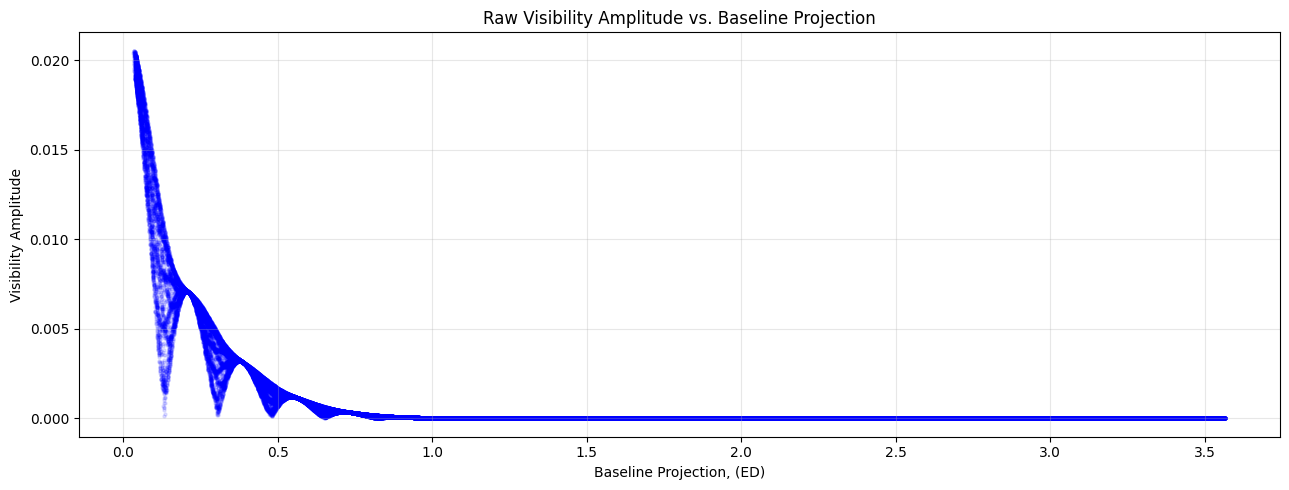

In [29]:
plot_scatter(x=dataset['Baseline'],
             y=dataset['Amplitude'],
             xlabel='Baseline Projection, (ED)',
             ylabel='Visibility Amplitude',
             title='Raw Visibility Amplitude vs. Baseline Projection',
             grid=True,
             figsize=(13, 5)
             )

In [30]:
# extract visibility amplitude along the cross-section
delta_test = 0.01
alpha_test = 45

filtered_data, mask, distance = cross_section(dataset, 
                                              delta=delta_test, 
                                              alpha_deg=alpha_test)

Angle: 45, (deg.)
Cross-section width: 0.01
Number of points: 1603/259200 (0.6%)


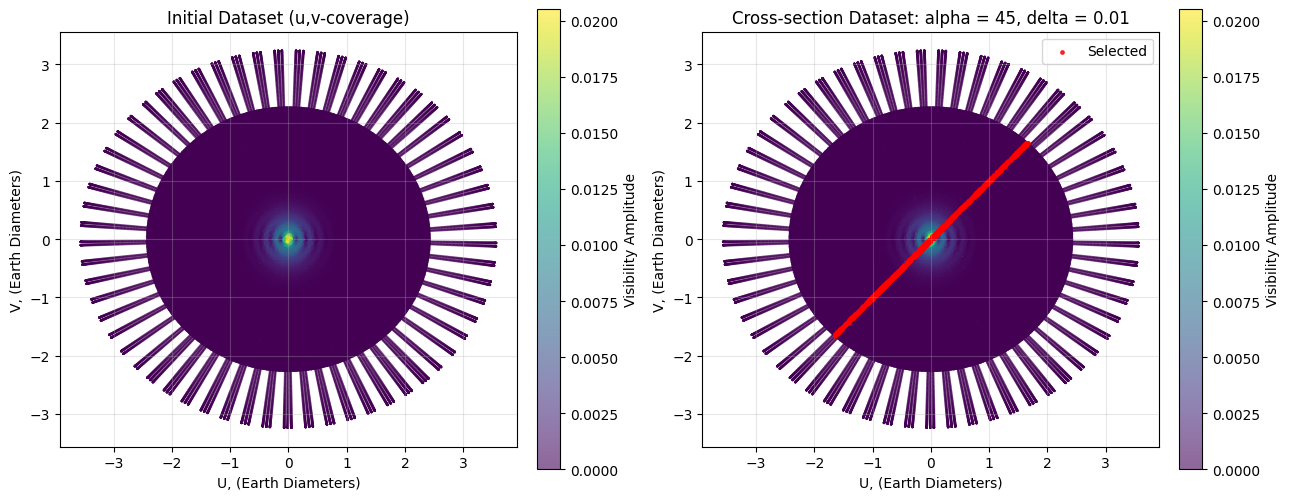

In [31]:
plot_uv_coverage(
    dataset=dataset,
    alpha_test=alpha_test,
    delta_test=delta_test,
    amplitude_col='Amplitude',
    u_col='U',
    v_col='V',
    figsize=(13, 6),
    point_size=3,
    alpha_val=0.6,
    cmap='viridis',
    selected_color='red'
);

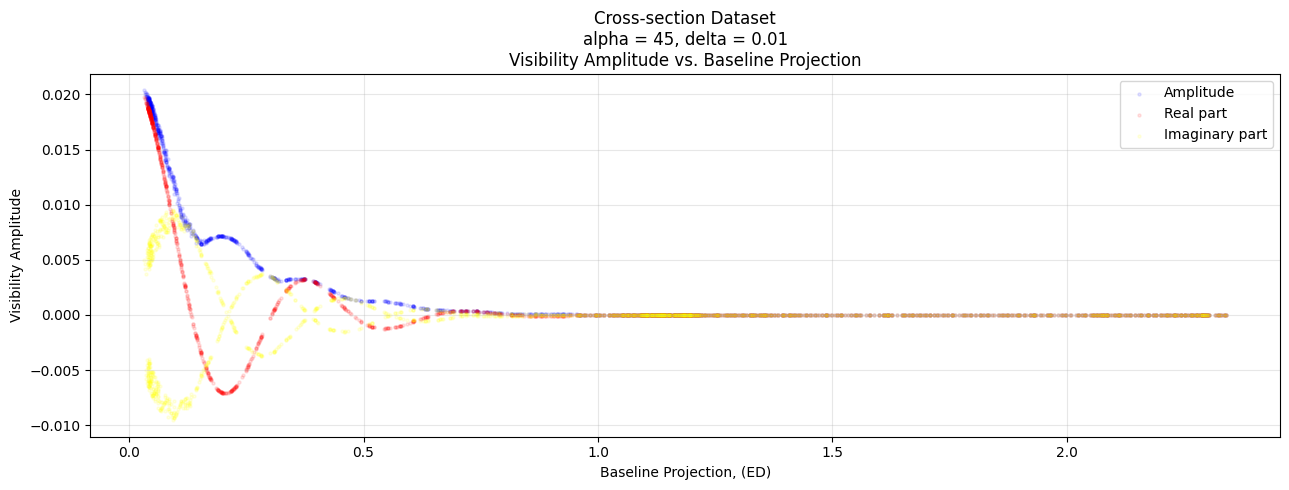

In [32]:
plot_visibility_components(
    filtered_data=filtered_data,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    real_col='Re',
    imag_col='Im',
    alpha=0.1,
    size=5,
    amplitude_color='blue',
    real_color='red',
    imag_color='yellow',
    figsize=(13, 5),
    xlabel='Baseline Projection, (ED)',
    ylabel='Visibility Amplitude',
    title_prefix='Cross-section Dataset',
    alpha_test=alpha_test,
    delta_test=delta_test,
    grid=True
);

## Data Prepartion

In [ ]:
selected_data, rest_data, used_ranges = select_by_baseline_ranges(
    dataset=filtered_data,
    baseline_col='Baseline',
    ranges=[(0.1, 0.2), (0.5, 0.6), (0.7, 0.8)],
    mode='specified'
)

In [ ]:
plot_amplitude_phase_with_selection(
    filtered_data, selected_data, used_ranges,
    alpha_test=alpha_test, delta_test=delta_test
);

**Comment**: next step is to prepare the dataset for further training, validation and testing of the model.

In [35]:
rest_data = rest_data.sort_values('Baseline').reset_index(drop=True)

X_data = rest_data[['U', 'V', 'Baseline']].values
y_data = rest_data[['Re', 'Im']].values

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_data)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_data)

X_tensor = torch.from_numpy(X_scaled).float()
y_tensor = torch.from_numpy(y_scaled).float()

In [ ]:
# creating initial dataset
dataset_model = create_dataset_from_data(X_tensor, y_tensor, train_ratio=1-TEST_SIZE, device=device)

In [ ]:
print("Training dataset input features dimensions:", dataset_model['train_input'].shape)
print("Training dataset target features dimensions:", dataset_model['train_label'].shape)
print("Validation dataset input features dimensions:", dataset_model['test_input'].shape)
print("Validation dataset target features dimensions:", dataset_model['test_label'].shape)

## Model Initialization

In [ ]:
# initialize model
model = KAN(width=[3, 12, 12, 2],
            grid=5,
            k=3,
            seed=RANDOM_STATE,
            device=device)


## Training

In [ ]:
history = model.fit(dataset_model,
                    opt="LBFGS",
                    steps=1000,
                    update_grid=True);

In [ ]:
model.plot()

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['test_loss'], label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss during KAN training')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

## Testing

### Selected Ranges

In [ ]:
test_data_raw = selected_data[['U', 'V', 'Baseline']].values
test_data_scaled = scaler_X.transform(test_data_raw)
test_data = torch.from_numpy(test_data_scaled).float()

In [ ]:
results_scaled = model(test_data)

In [ ]:
results_denormalized = scaler_y.inverse_transform(results_scaled.detach().numpy())
results_amplitude = np.sqrt(results_denormalized[:, 0]**2 + results_denormalized[:, 1]**2)
results_phase = np.arctan2(results_denormalized[:, 1] / results_denormalized[:, 0])

In [ ]:
fig, axs = plot_predictions_comparison(
    filtered_data, selected_data, results_amplitude, results_phase, used_ranges,
    alpha_test=alpha_test, delta_test=delta_test
)

### Whole Dataset

In [ ]:
whole_data_raw = filtered_data[['U', 'V', 'Baseline']].values
whole_data_scaled = scaler_X.transform(whole_data_raw)
whole_data = torch.from_numpy(whole_data_scaled).float()


In [ ]:
results_whole_scaled = model(whole_data)


In [ ]:
results_whole_denormalized = scaler_y.inverse_transform(results_whole_scaled.detach().numpy())
results_whole = np.sqrt(results_whole_denormalized[:, 0]**2 + results_whole_denormalized[:, 1]**2)
results_phase_whole = np.arctan2(results_whole_denormalized[:, 1] / results_whole_denormalized[:, 0])

In [ ]:
fig, axs = plot_whole_predictions(
    filtered_data, results_whole, results_phase_whole, used_ranges,
    alpha_test=alpha_test, delta_test=delta_test
)

In [ ]:
fig, stats = plot_residuals_analysis(
    filtered_data=filtered_data,
    results_amplitude=results_whole,
    results_denormalized=results_phase_whole,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    phase_col='Phase',
    alpha_test=alpha_test,
    delta_test=delta_test,
    figsize=(16, 8),
    return_stats=True
)

## Results and Discussions

# Crest Model Dataset (Noise Injection)

## Noise Injection

In [ ]:
filtered_data_noisy = add_noise(filtered_data, 
                                re_noise_percent=10, 
                                im_noise_percent=10, 
                                random_seed=RANDOM_STATE)

# calculate visibility amplitude and phase and add it to initial dataset
calculate_baseline_amplitude(dataset=filtered_data_noisy, inplace=True, sort_baselines=True)

## EDA

In [ ]:
plot_visibility_components(
    filtered_data=filtered_data_noisy,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    real_col='Re',
    imag_col='Im',
    alpha=0.1,
    size=5,
    amplitude_color='blue',
    real_color='red',
    imag_color='yellow',
    figsize=(13, 5),
    xlabel='Baseline Projection, (ED)',
    ylabel='Visibility Amplitude',
    title_prefix='Cross-section Dataset (Injected Noise: 10%)',
    alpha_test=alpha_test,
    delta_test=delta_test,
    grid=True
);

## Data Preparation

In [ ]:
selected_data_noisy, rest_data_noisy, used_ranges = select_by_baseline_ranges(dataset=filtered_data_noisy,
                                                                  baseline_col='Baseline',
                                                                  ranges=[(0.1, 0.2), (0.5, 0.6), (0.7, 0.8)],
                                                                  mode='specified'
                                                                  )

In [ ]:
plot_amplitude_phase_with_selection(filtered_data_noisy, selected_data_noisy, used_ranges,
                                    alpha_test=alpha_test, delta_test=delta_test);

In [ ]:
rest_data_noisy = rest_data_noisy.sort_values('Baseline').reset_index(drop=True)

X_data = rest_data_noisy[['U', 'V', 'Baseline']].values
y_data = rest_data_noisy[['Re', 'Im']].values

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_data)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_data)

X_tensor = torch.from_numpy(X_scaled).float()
y_tensor = torch.from_numpy(y_scaled).float()

In [ ]:
# creating initial dataset
dataset_noisy = create_dataset_from_data(X_tensor, y_tensor, train_ratio=1-TEST_SIZE, device=device)

In [ ]:
# initialize model
model_noisy = KAN(width=[3, 12, 12, 2],
            grid=5,
            k=3,
            seed=RANDOM_STATE,
            device=device)

## Training

In [ ]:
history_noisy = model_noisy.fit(dataset_noisy,
                            opt="LBFGS",
                            steps=1000,
                            update_grid=True);

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(history_noisy['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history_noisy['test_loss'], label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss during KAN training (Injected Noise: 10%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

## Testing

### Selected Ranges

In [ ]:
test_data_raw = selected_data_noisy[['U', 'V', 'Baseline']].values
test_data_scaled = scaler_X.transform(test_data_raw)
test_data = torch.from_numpy(test_data_scaled).float()

In [ ]:
results_scaled = model(test_data)

In [ ]:
results_denormalized = scaler_y.inverse_transform(results_scaled.detach().numpy())
results_amplitude_noisy = np.sqrt(results_denormalized[:, 0]**2 + results_denormalized[:, 1]**2)
results_phase_noisy = np.atan2(results_denormalized[:, 1], results_denormalized[:, 0])

In [ ]:
fig, axs = plot_predictions_comparison(filtered_data_noisy, selected_data_noisy, results_amplitude_noisy, 
                                       results_phase_noisy, used_ranges,
                                       alpha_test=alpha_test, delta_test=delta_test)

### Whole Dataset

In [ ]:
whole_data_raw = filtered_data_noisy[['U', 'V', 'Baseline']].values
whole_data_scaled = scaler_X.transform(whole_data_raw)
whole_data = torch.from_numpy(whole_data_scaled).float()

In [ ]:
results_whole_scaled = model(whole_data)

In [ ]:
results_whole_denormalized = scaler_y.inverse_transform(results_whole_scaled.detach().numpy())
results_amplitude_whole_noisy = np.sqrt(results_whole_denormalized[:, 0]**2 + results_whole_denormalized[:, 1]**2)
results_phase_whole_noisy = np.atan2(results_whole_denormalized[:, 1], results_whole_denormalized[:, 0])

In [ ]:
fig, axs = plot_whole_predictions(filtered_data_noisy, results_amplitude_whole_noisy, results_phase_whole_noisy, 
                                  used_ranges, alpha_test=alpha_test, delta_test=delta_test)

In [ ]:
fig, stats = plot_residuals_analysis(
    filtered_data=filtered_data_noisy,
    results_amplitude=results_amplitude_whole_noisy,
    results_denormalized=results_phase_whole_noisy,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    phase_col='Phase',
    alpha_test=alpha_test,
    delta_test=delta_test,
    figsize=(16, 8),
    return_stats=True
)